In [203]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow import keras
from tensorflow.keras import layers, Input
from tensorflow.keras.layers import LayerNormalization
from tensorflow.keras.optimizers import Adam

from glob import glob

monet_path = ("gan-getting-started/monet_jpg")
photo_path = ("gan-getting-started/photo_jpg")

### Week 5: Monet Painting Generation

#### Problem
This project involves analyzing various paintings by Monet and creating an ML model that can modify photos to have a similar aesthetic as Monet's paintings. This data is sourced from https://www.kaggle.com/competitions/gan-getting-started/overview, containing 300 paintings by Monet, as well as various photos to try and stylize.

#### EDA
Show a few visualizations like histograms. Describe any data cleaning procedures. Based on your EDA, what is your plan of analysis?

First, I'll take a look at the provided Monet images. There are 300 images total, all of them 256x256 images.

Total images:  300
Image sizes:  {(256, 256)}


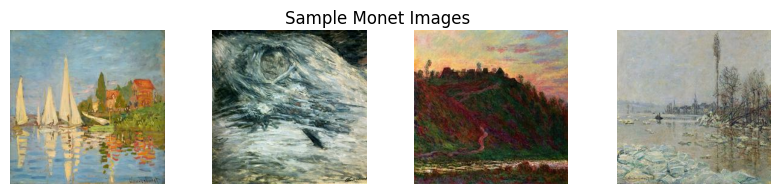

In [182]:
monet_images = glob(monet_path + "/*.jpg")

def image_sample(images, title):
    print("Total images: ", len(images))
    
    plt.figure(figsize=(10, 2))
    
    size_set = set()

    for image in images:
        img = load_img(image)
        size_set.add(img.size)
    
    for i, img_path in enumerate(images[:4]):
        img = load_img(img_path)    
        plt.subplot(1, 4, i + 1)  
        plt.imshow(img) 
        plt.axis('off')  
    
    plt.suptitle(f'Sample {title} Images') 
    
    print("Image sizes: ", size_set)
    
    plt.show()

image_sample(monet_images, "Monet")

I'll take a look at the Photos as well. There's 7038 total, all 256x256 images again, so I won't need to resize any images.

Total images:  7038
Image sizes:  {(256, 256)}


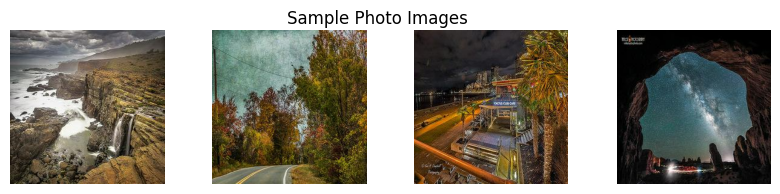

In [183]:
photo_images = glob(photo_path + "/*.jpg")
image_sample(photo_images, "Photo")

Next, I'll preprocess the training images (I want to normalize the values and set the batch size), and create the training dataset.

In [185]:
def convert_img(image_path):
    img = load_img(image_path, target_size=(256, 256))  # target_size=(128, 128) # Changed from 256x256
    img_array = img_to_array(img)
    img_array = (img_array - 127.5) / 127.5  # Normalize to [-1, 1]
    return img_array
    
monet_arrs = np.array([convert_img(img) for img in monet_images])

BATCH_SIZE = 64
BUFFER_SIZE = 300  # Shuffle buffer size

# Create a TensorFlow dataset
dataset = tf.data.Dataset.from_tensor_slices(monet_arrs)

# Shuffle and batch the dataset
monet_dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)  # Prefetch to improve performance
)



# Inspect a batch of images
# for batch in train_dataset.take(1):
#     # Denormalize images to [0, 1] for visualization
#     batch = (batch + 1.0) / 2.0  
#     for i in range(9):  # Display 9 images
#         plt.subplot(3, 3, i + 1)
#         plt.imshow(batch[i])
#         plt.axis('off')
#     plt.show()

#### Model Architecture
Describe your model architecture and reasoning for why you believe that specific architecture would be suitable for this problem.

Building the generator component for the GAN. The goal is to take in random noise as an input, and then upsample into a 256x256x3 image as output.

In [186]:
# Build Generator
def build_gen(latent_dim):
    model = tf.keras.Sequential([
        layers.Dense(16 * 16 * 512, use_bias=False, input_shape=(latent_dim,), kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Reshape((16, 16, 512)),
    
        # Need to Upsample to 128x128    
        layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(), # (32, 32, 256) Shape

        layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(), # (64, 64, 128)

        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(), # (128, 128, 64)

        layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(), # (256, 256, 32)

        layers.Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', activation='tanh')  # (256, 256, 3)
    ])
    return model

latent_dim = 100
generator = build_gen(latent_dim)
generator.summary()

Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_23 (Dense)                │ (None, 131072)         │    13,107,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_58          │ (None, 131072)         │       524,288 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_90 (LeakyReLU)      │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_12 (Reshape)            │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_58             │ (None, 32, 32, 256)    │     3,276,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_59          │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_91 (LeakyReLU)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_59             │ (None, 64, 64, 128)    │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_60          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_92 (LeakyReLU)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_60             │ (None, 128, 128, 64)   │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_61          │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_93 (LeakyReLU)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_61             │ (None, 256, 256, 32)   │        51,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_62          │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_94 (LeakyReLU)      │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_62             │ (None, 256, 256, 3)    │         2,403 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,987,811 (68.62 MB)

 Trainable params: 17,724,707 (67.61 MB)

 Non-trainable params: 263,104 (1.00 MB)

Similarly, the discriminator needs to take in a 256x256x3 image, and determine if it's real or fake.

In [199]:
# Build Discriminator
def build_discriminator():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(256, 256, 3)),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        
        layers.Flatten(),
        layers.Dense(1, activation='sigmoid') 
    ])
    return model

discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_42 (Conv2D)              │ (None, 128, 128, 64)   │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_105 (LeakyReLU)     │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 64, 64, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_106 (LeakyReLU)     │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 32, 32, 256)    │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_107 (LeakyReLU)     │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 16, 16, 512)    │     3,277,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_108 (LeakyReLU)     │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 512)            │    67,109,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,416,449 (272.43 MB)

 Trainable params: 71,416,449 (272.43 MB)

 Non-trainable params: 0 (0.00 B)

Initializingi the optimizers (using Adam, with 0.0001 learning rate to start off), and setting up the loss functions for the generator and discriminator. The Discriminator will use Binary Cross Entropy (since it should return 0/1. I set trainable to False so it freezes while training the generator.

#### Results and Analysis
Run hyperparameter tuning, try different architectures for comparison, apply techniques to improve training or performance, and discuss what helped.

Includes results with tables and figures. There is an analysis of why or why not something worked well, troubleshooting, and a hyperparameter optimization procedure summary.

Copied from Week 4, might not apply.

In [208]:
# Model Compilation

generator_optimizer = Adam(learning_rate=0.00001)
discriminator_optimizer = Adam(learning_rate=0.00001)

discriminator.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),  
    optimizer=discriminator_optimizer,
    metrics=['accuracy']
)

discriminator.trainable = False 

gan = tf.keras.Sequential([generator, discriminator])
gan.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), #from_logits=True
    optimizer=generator_optimizer
)

print("Discriminator trainable variables:", len(discriminator.trainable_variables))


Discriminator trainable variables: 0


Defining the training loop for the GAN (Generating real and fake images, and passing to the discriminator to train) 

In [209]:
# Define the latent dimension (size of noise input for the generator)
latent_dim = 100

# Function to generate and save images during training
def generate_and_save_images(generator, epoch, num_examples=16):
    noise = tf.random.normal([num_examples, latent_dim])
    generated_images = generator(noise, training=False)
    
    # Rescale images to [0, 1] for visualization
    generated_images = (generated_images + 1.0) / 2.0
    
    # Plot the generated images
    fig, axes = plt.subplots(4, 4, figsize=(6, 6))
    for i, ax in enumerate(axes.flat):
        ax.imshow(generated_images[i])
        ax.axis('off')
    plt.savefig(f'generated_images_epoch_{epoch:03d}.png')
    plt.close()

# Training step function
@tf.function
def train_step(real_images):
    batch_size = real_images.shape[0]
    
    # Step 1: Train the discriminator
    discriminator.trainable = True 
    noise = tf.random.normal([batch_size, LATENT_DIM])  # Random noise
    fake_images = generator(noise, training=True)  # Generate fake images

    # Create labels for real and fake images
    real_labels = tf.ones((batch_size, 1))  # Real = 1
    fake_labels = tf.zeros((batch_size, 1))  # Fake = 0

    # Train the discriminator with real and fake images
    with tf.GradientTape() as disc_tape:
        real_output = discriminator(real_images, training=True)
        fake_output = discriminator(fake_images, training=True)
        disc_loss = (
            tf.keras.losses.binary_crossentropy(real_labels, real_output) +
            tf.keras.losses.binary_crossentropy(fake_labels, fake_output)
        )

    # Apply gradients to the discriminator
    disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))

    # Step 2: Train the generator
    discriminator.trainable = False 
    noise = tf.random.normal([batch_size, LATENT_DIM])
    misleading_labels = tf.ones((batch_size, 1))  # Generator wants discriminator to classify as real

    with tf.GradientTape() as gen_tape:
        fake_images = generator(noise, training=True)
        fake_output = discriminator(fake_images, training=True)
        gen_loss = tf.keras.losses.binary_crossentropy(misleading_labels, fake_output)

    # Apply gradients to the generator
    gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))

    return gen_loss, disc_loss

# Training loop
def train_gan(train_dataset, epochs):
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        
        gen_loss_epoch = []
        disc_loss_epoch = []

        for real_images in train_dataset:
            gen_loss, disc_loss = train_step(real_images)
            gen_loss_epoch.append(gen_loss.numpy().mean())
            disc_loss_epoch.append(disc_loss.numpy().mean())

        # Log losses
        print(f"Generator Loss: {np.mean(gen_loss_epoch):.4f}, Discriminator Loss: {np.mean(disc_loss_epoch):.4f}")
        
        # Generate and save images every 10 epochs
        if (epoch + 1) % 10 == 0:
            generate_and_save_images(generator, epoch + 1)

# Train the GAN
epochs = 30
train_gan(train_dataset, epochs)

for batch in train_dataset.take(1):  # Take a single batch
    print(batch.shape)


Epoch 1/30
64
64
44
Generator Loss: 1.1816, Discriminator Loss: 1.2353
Epoch 2/30
Generator Loss: 1.5543, Discriminator Loss: 0.8991
Epoch 3/30
Generator Loss: 1.9250, Discriminator Loss: 0.5478
Epoch 4/30
Generator Loss: 3.0096, Discriminator Loss: 0.2730
Epoch 5/30
Generator Loss: 3.6230, Discriminator Loss: 0.1325
Epoch 6/30
Generator Loss: 4.3004, Discriminator Loss: 0.0776
Epoch 7/30
Generator Loss: 4.7503, Discriminator Loss: 0.0643
Epoch 8/30
Generator Loss: 4.7519, Discriminator Loss: 0.0732
Epoch 9/30
Generator Loss: 4.9502, Discriminator Loss: 0.0828
Epoch 10/30
Generator Loss: 5.4222, Discriminator Loss: 0.0798
Epoch 11/30
Generator Loss: 5.4223, Discriminator Loss: 0.0537
Epoch 12/30
Generator Loss: 6.5260, Discriminator Loss: 0.0293
Epoch 13/30
Generator Loss: 6.1877, Discriminator Loss: 0.0236
Epoch 14/30
Generator Loss: 6.8038, Discriminator Loss: 0.0240
Epoch 15/30
Generator Loss: 6.3446, Discriminator Loss: 0.0264
Epoch 16/30
Generator Loss: 6.8164, Discriminator Loss:

2024-12-06 16:19:36.619854: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 7.0752, Discriminator Loss: 0.0213
Epoch 18/30
Generator Loss: 6.8850, Discriminator Loss: 0.0244
Epoch 19/30
Generator Loss: 7.0507, Discriminator Loss: 0.0223
Epoch 20/30
Generator Loss: 7.1109, Discriminator Loss: 0.0254
Epoch 21/30
Generator Loss: 6.9420, Discriminator Loss: 0.0215
Epoch 22/30
Generator Loss: 7.6287, Discriminator Loss: 0.0173
Epoch 23/30
Generator Loss: 7.1440, Discriminator Loss: 0.0185
Epoch 24/30
Generator Loss: 8.4359, Discriminator Loss: 0.0145
Epoch 25/30
Generator Loss: 6.8372, Discriminator Loss: 0.0132
Epoch 26/30
Generator Loss: 7.6110, Discriminator Loss: 0.0122
Epoch 27/30
Generator Loss: 7.4018, Discriminator Loss: 0.0193
Epoch 28/30
Generator Loss: 7.6653, Discriminator Loss: 0.0197
Epoch 29/30
Generator Loss: 7.7616, Discriminator Loss: 0.0183
Epoch 30/30
Generator Loss: 7.8186, Discriminator Loss: 0.0148
(64, 256, 256, 3)


#### Conclusion

Discuss and interpret results as well as learnings and takeaways. What did and did not help improve the performance of your models? What improvements could you try in the future?

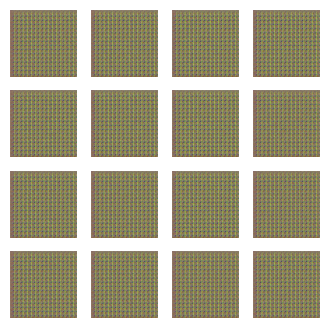

In [211]:
def generate_and_save_images(generator, epoch, latent_dim, num_examples=16):
    noise = tf.random.normal([num_examples, latent_dim])
    generated_images = generator(noise, training=False)
    generated_images = (generated_images + 1) / 2  # Rescale from [-1,1] (tanh output) to [0, 1]

    plt.figure(figsize=(4, 4))
    for i in range(num_examples):
        plt.subplot(4, 4, i + 1)
        plt.imshow(generated_images[i])
        plt.axis('off')
    plt.show()

generate_and_save_images(generator, 1, latent_dim)
# noise = tf.random.normal([1, latent_dim])
# generated_image = generator(noise, training=False)
# print(tf.reduce_min(generated_image), tf.reduce_max(generated_image))  # Check value range
# plt.imshow((generated_image[0] + 1) / 2)  # Rescale and visualize

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


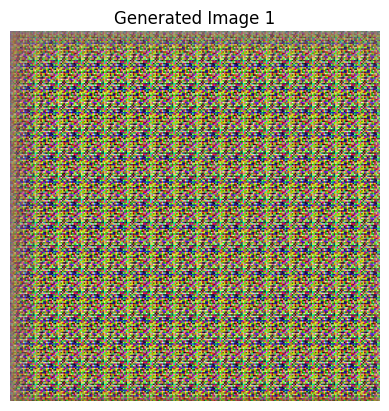

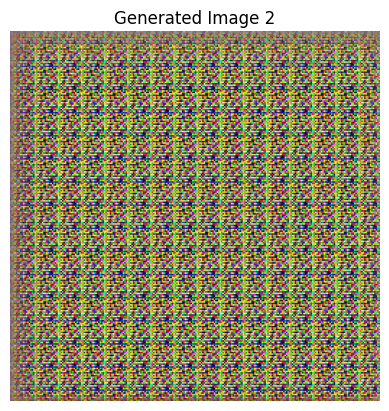

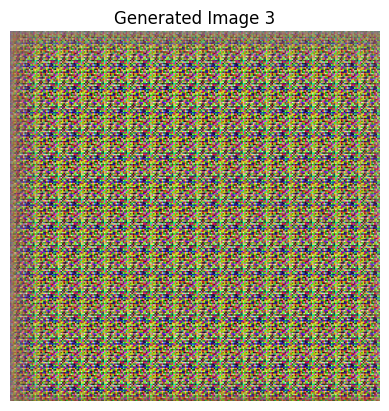

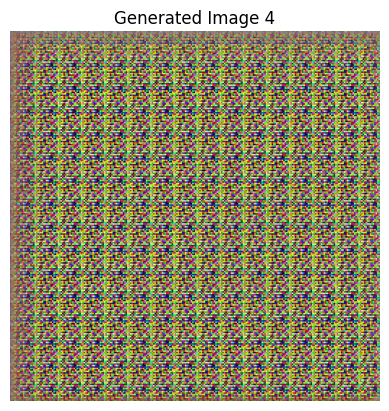

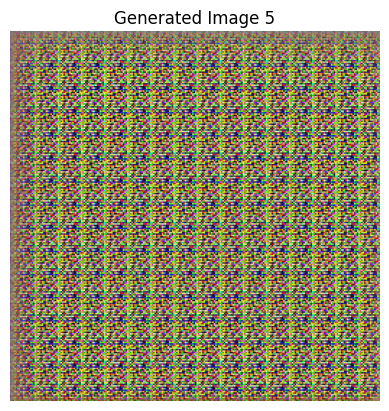

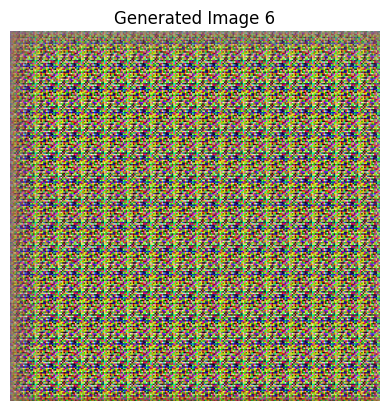

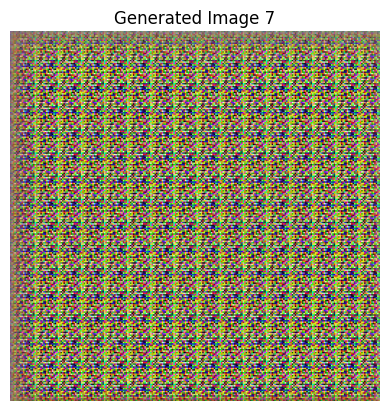

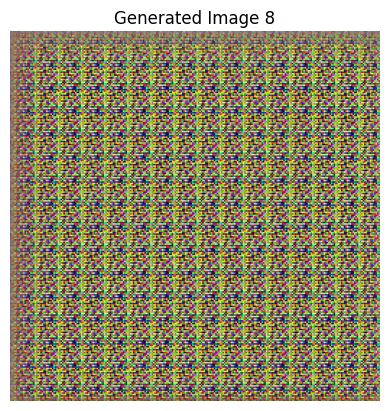

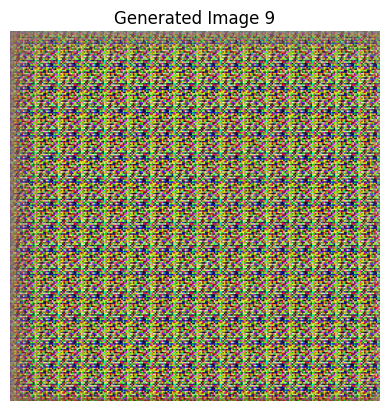

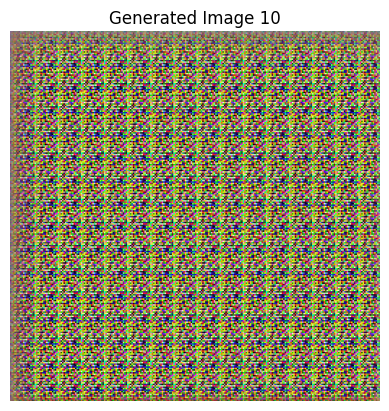

In [213]:
noise = tf.random.normal([10, latent_dim])
generated_images = generator.predict(noise)

def denormalize_image(image):
    # If images were normalized to [-1, 1], denormalize to [0, 255]
    image = (image + 1) * 127.5  # [-1, 1] -> [0, 255]
    return np.clip(image, 0, 255).astype(np.uint8)

# Denormalize and plot an image
for i, img in enumerate(generated_images):
    img = denormalize_image(img)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Generated Image {i + 1}")
    plt.show()


Noise Min: -3.659577 Noise Max: 3.3023834


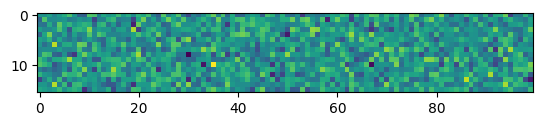

In [92]:
noise = tf.random.normal([16, latent_dim])
print("Noise Min:", tf.reduce_min(noise).numpy(), "Noise Max:", tf.reduce_max(noise).numpy())
plt.imshow((noise + 1) / 2)
